In [ ]:
from datetime import datetime
from meteostat import Hourly, Point
import pandas as pd

# 1) 定义 Oak Ridge, TN 坐标
oak_ridge = Point(36.010, -84.269)

# 2) 定义时间范围（2023年全年的每小时）
start = datetime(2023, 1, 1)
end   = datetime(2023, 12, 31, 23, 59)

# 3) 获取逐小时天气数据（UTC）
df = Hourly(oak_ridge, start, end).fetch()


# 4) 转换为纽约本地时间（America/New_York），再去掉时区信息
df.index = df.index.tz_localize('UTC').tz_convert('America/New_York').tz_localize(None)

# 5) 仅保留温度（°C）
out = df[['temp']].copy()
out.index.name = 'datetime_local'

# 6) 保存为 CSV（时间为本地时间、无时区）
out.reset_index().to_csv('oak_ridge_tn_hourly_temp_2023_meteostat_local.csv', index=False)

print("✅ Saved: oak_ridge_tn_hourly_temp_2023_meteostat_local.csv")
print(out.head())


✅ Saved: oak_ridge_tn_hourly_temp_2023_meteostat_local.csv
                     temp
datetime_local           
2022-12-31 19:00:00  12.0
2022-12-31 20:00:00  11.0
2022-12-31 21:00:00  10.0
2022-12-31 22:00:00  10.0
2022-12-31 23:00:00   9.0


In [38]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# =========================
# Utility: read CSV and clean columns
# =========================
def read_csv_clean(path, datetime_cols=None):
    """
    Read a CSV file and automatically:
    1) Drop columns that are entirely NaN
    2) Drop columns with names like 'Unnamed: x'
    3) Optionally parse datetime columns
    Returns (df, removed_cols) for transparency
    """
    df_raw = pd.read_csv(path)
    original_cols = df_raw.columns.tolist()

    # Drop fully NaN columns
    df = df_raw.dropna(axis=1, how='all')

    # Drop 'Unnamed' columns
    unnamed_mask = df.columns.str.contains(r'^Unnamed', case=False, regex=True)
    df = df.loc[:, ~unnamed_mask]

    # Parse datetime columns
    if datetime_cols:
        for c in datetime_cols:
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors='coerce')

    removed_cols = [c for c in original_cols if c not in df.columns]
    return df, removed_cols


# =========================
# 1) Read Frontier power data
# =========================
frontier_path = "Frontier HPC & Facility Data.csv"
frontier, frontier_removed = read_csv_clean(frontier_path, datetime_cols=["Date/Time"])

# Rename columns
frontier = frontier.rename(columns={
    'Frontier Compute Power(MW)': 'Compute Power',
    'Frontier Facility accessory Power(MW)': 'Accessory Power',
    'Frontier Total Power(MW)': 'Total Power'
})

# =========================
# 2) Resample to hourly averages
# =========================
frontier_hourly = (
    frontier.resample('H', on='Date/Time')
    .mean(numeric_only=True)
    .reset_index()
)

# =========================
# 3) Read temperature data
# =========================
temp_path = "oak_ridge_tn_hourly_temp_2023_meteostat_local.csv"
temp, temp_removed = read_csv_clean(temp_path, datetime_cols=["datetime_local"])

# Rename columns
temp = temp.rename(columns={'datetime_local': 'Date/Time', 'temp': 'Temperature'})

# =========================
# 4) Filter for 2023 only and merge
# =========================
frontier_hourly = frontier_hourly[frontier_hourly['Date/Time'].dt.year == 2023].copy()
temp = temp[temp['Date/Time'].dt.year == 2023].copy()

# Merge and sort
df = pd.merge(frontier_hourly, temp, on='Date/Time', how='inner').sort_values('Date/Time')

# Remove any remaining Unnamed or NaN-only columns
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed', case=False, regex=True)]

# =========================
# 5) Save merged dataset
# =========================
output_path = "merged_frontier_temperature_hourly_2023.csv"
df.to_csv(output_path, index=False)

print("✅ Merged CSV saved:", output_path)
print("📦 Rows:", len(df))
print("🧹 Removed columns from Frontier:", frontier_removed if frontier_removed else "None")
print("🧹 Removed columns from Temperature:", temp_removed if temp_removed else "None")
print("\nColumns after merge:", list(df.columns))

# =========================
# 6) Plot with Plotly
# =========================
fig = go.Figure()

# Compute Power (blue bars)
fig.add_trace(go.Bar(
    x=df['Date/Time'],
    y=df['Compute Power'],
    name='Compute Power',
    marker_color='blue',
    hovertemplate='Time: %{x|%Y-%m-%d %H:%M}<br>Compute: %{y:.3f} MW<extra></extra>'
))

# Accessory Power (orange bars stacked)
fig.add_trace(go.Bar(
    x=df['Date/Time'],
    y=df['Accessory Power'],
    name='Accessory Power',
    marker_color='orange',
    hovertemplate='Time: %{x|%Y-%m-%d %H:%M}<br>Accessory: %{y:.3f} MW<extra></extra>'
))

# Temperature (red dots, right axis)
fig.add_trace(go.Scatter(
    x=df['Date/Time'],
    y=df['Temperature'],
    name='Temperature',
    mode='markers',
    marker=dict(size=3, color='red'),
    yaxis='y2',
    hovertemplate='Time: %{x|%Y-%m-%d %H:%M}<br>Temp: %{y:.1f} °C<extra></extra>'
))

# =========================
# 7) Layout
# =========================
fig.update_layout(
    title='Frontier Power vs Oak Ridge Temperature — 2023 Hourly Averages',
    barmode='stack',
    xaxis=dict(title='Time (Hourly)', tickformat='%m-%d'),
    yaxis=dict(title='Power (MW)'),
    yaxis2=dict(title='Temperature (°C)', overlaying='y', side='right'),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0),
    template='plotly_white',
    bargap=0,
    height=600,
    width=1200
)

fig.show()


✅ Merged CSV saved: merged_frontier_temperature_hourly_2023.csv
📦 Rows: 8755
🧹 Removed columns from Frontier: ['Unnamed: 5', 'Unnamed: 6']
🧹 Removed columns from Temperature: None

Columns after merge: ['Date/Time', 'Compute Power', 'Accessory Power', 'Total Power', 'Power Usage Effectiveness(100%)', 'Temperature']


In [27]:
import pandas as pd
import plotly.graph_objects as go

# === 1. Load the merged hourly dataset ===
df = pd.read_csv("merged_frontier_temperature_hourly_2023.csv")
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# === 2. Compute Accessory Power percentage ===
df['Accessory % of Total'] = (df['Accessory Power'] / df['Total Power']) * 100

# === 3. Create Plotly figure ===
fig = go.Figure()

# Left Y-axis: Accessory % of Total
fig.add_trace(go.Scatter(
    x=df['Date/Time'],
    y=df['Accessory % of Total'],
    name='Accessory % of Total Power',
    mode='lines',
    line=dict(color='orange', width=1.5)
))

# Right Y-axis: Temperature
fig.add_trace(go.Scatter(
    x=df['Date/Time'],
    y=df['Temperature'],
    name='Temperature (°C)',
    mode='lines+markers',
    line=dict(color='red', width=1),
    marker=dict(size=2),
    yaxis='y2'
))

# === 4. Layout settings ===
fig.update_layout(
    title='Accessory Power Percentage vs Temperature — 2023 Hourly Data',
    xaxis=dict(title='Time (Hourly)', tickformat='%m-%d'),
    yaxis=dict(title='Accessory Power (% of Total)', side='left'),
    yaxis2=dict(title='Temperature (°C)', overlaying='y', side='right'),
    template='plotly_white',
    height=500,
    width=1400,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0)
)

fig.show()


Sampling interval: 1.000 hours/sample
Top 10 dominant periods (with phase info):
-----------------------------------------------------------
1. Frequency = 0.0027 cycles/day, Amplitude = 1.63 (norm=1.0000), Period = 364.792 days (8755.0 h), Phase = 0.814 rad, Peak at 87.0% of cycle (~7620.1 h after start)
2. Frequency = 0.0055 cycles/day, Amplitude = 1.57 (norm=0.9613), Period = 182.396 days (4377.5 h), Phase = -2.101 rad, Peak at 33.4% of cycle (~1463.5 h after start)
3. Frequency = 0.0164 cycles/day, Amplitude = 1.53 (norm=0.9393), Period = 60.799 days (1459.2 h), Phase = 0.148 rad, Peak at 97.6% of cycle (~1424.8 h after start)
4. Frequency = 0.0110 cycles/day, Amplitude = 1.52 (norm=0.9281), Period = 91.198 days (2188.8 h), Phase = -1.105 rad, Peak at 17.6% of cycle (~384.8 h after start)
5. Frequency = 0.0082 cycles/day, Amplitude = 1.50 (norm=0.9163), Period = 121.597 days (2918.3 h), Phase = 1.656 rad, Peak at 73.6% of cycle (~2149.2 h after start)
6. Frequency = 0.0192 cycles/d

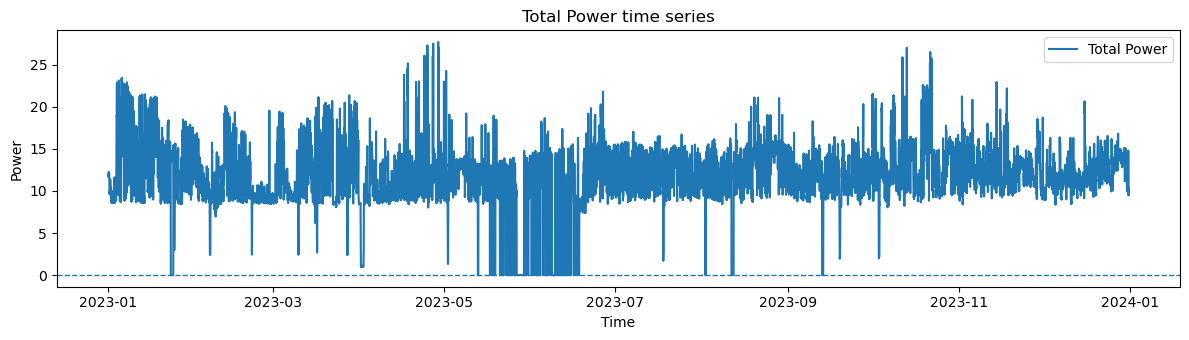

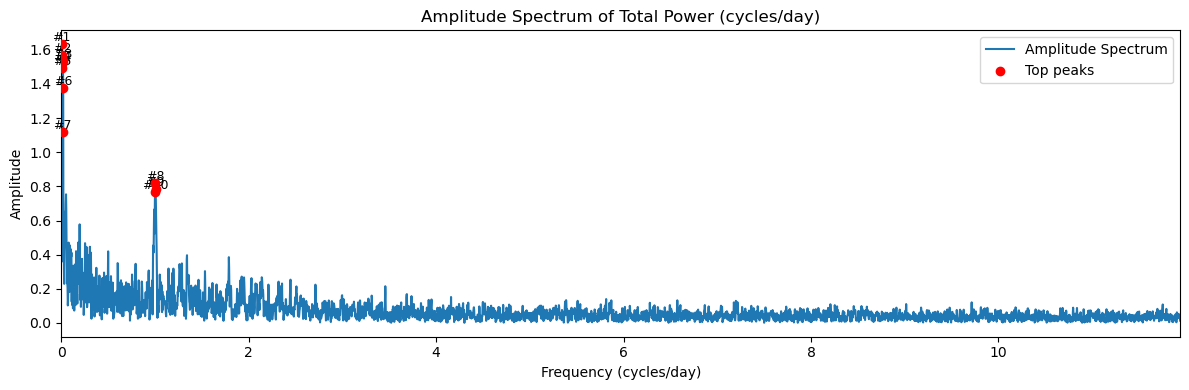

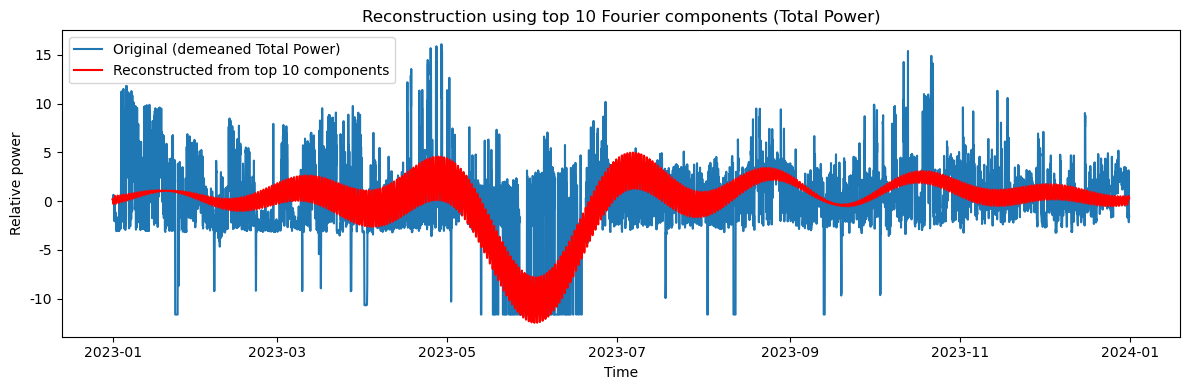

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ==================== SETTINGS ====================
csv_path = Path("merged_frontier_temperature_hourly_2023.csv")  # Input CSV
top_k = 10                              # Number of dominant frequencies to report
resample_rule = "1H"                    # Hourly sampling
# ==================================================

# 1) Read data
use_cols = ["Date/Time", "Total Power"]
df = pd.read_csv(csv_path, usecols=use_cols, parse_dates=["Date/Time"])

# Set time index and sort
df = df.set_index("Date/Time").sort_index()

# Ensure numeric Total Power
df["Total Power"] = pd.to_numeric(df["Total Power"], errors="coerce").fillna(0.0)

# 1.2 Resample to hourly mean & interpolate if there are gaps
s = df["Total Power"].resample(resample_rule).mean().interpolate("time")

# Sampling interval (hours)
dt_hours = (s.index[1] - s.index[0]).total_seconds() / 3600.0

# 2) Demean & apply Hann window
x = s.values.astype(float)
x = x - np.nanmean(x)
window = np.hanning(len(x))
xw = x * window

# 3) FFT
X = np.fft.rfft(xw)
window_correction = np.sum(window) / len(window)
X = X / (len(x) * window_correction)

freq_cph = np.fft.rfftfreq(len(x), d=dt_hours)  # cycles per hour
freq_cpd = freq_cph * 24.0                      # cycles per day
amplitude = np.abs(X)
phase = np.angle(X)
if len(amplitude) > 1:
    amplitude[1:-1] *= 2.0  # single-sided amplitude correction (exclude DC & Nyquist)

# 4) Select top_k positive frequencies (exclude DC)
mask = freq_cpd > 0
freq_pos = freq_cpd[mask]
amp_pos = amplitude[mask]
phase_pos = phase[mask]

amp_pos_max = np.max(amp_pos) if amp_pos.size > 0 else 0.0
amp_pos_norm = (amp_pos / amp_pos_max) if amp_pos_max > 0 else np.zeros_like(amp_pos)

idx = np.argsort(amp_pos)[::-1][:top_k]
dominant_freqs = freq_pos[idx]
dominant_amps = amp_pos[idx]
dominant_amps_norm = amp_pos_norm[idx]
dominant_phases = phase_pos[idx]
dominant_period_days = 1.0 / dominant_freqs
dominant_period_hours = dominant_period_days * 24.0

# 5) Print main results
print(f"Sampling interval: {dt_hours:.3f} hours/sample")
print(f"Top {top_k} dominant periods (with phase info):")
print("-----------------------------------------------------------")
for i, (f, a, a_norm, phi, pdays, phours) in enumerate(
    zip(dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases,
        dominant_period_days, dominant_period_hours), 1
):
    peak_fraction = (-phi / (2 * np.pi)) % 1.0
    peak_hours = peak_fraction * phours
    print(
        f"{i}. Frequency = {f:.4f} cycles/day, "
        f"Amplitude = {a:,.2f} (norm={a_norm:.4f}), "
        f"Period = {pdays:.3f} days ({phours:.1f} h), "
        f"Phase = {phi:.3f} rad, "
        f"Peak at {peak_fraction*100:.1f}% of cycle (~{peak_hours:.1f} h after start)"
    )

# === (5.1) Machine-readable JSON summary ===
results = {
    "resample_rule": str(resample_rule),
    "top_k": int(top_k),
    "n_samples": int(len(x)),
    "sampling_interval_hours": float(dt_hours),
    "time_start": s.index[0].isoformat(),
    "time_end": s.index[-1].isoformat(),
    "signal": "Total Power",
    "amplitude_normalization": {
        "method": "max_of_positive_frequencies",
        "reference_max_amplitude": float(amp_pos_max),
        "note": "amplitude_normalized = amplitude / max(amplitude over positive frequencies; DC excluded)"
    },
    "dominant_components": []
}

for f, a, a_norm, phi, pdays, phours in zip(
    dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases,
    dominant_period_days, dominant_period_hours
):
    peak_fraction = float((-phi / (2 * np.pi)) % 1.0)
    peak_hours = float(peak_fraction * phours)
    results["dominant_components"].append({
        "frequency_cycles_per_day": float(f),
        "amplitude": float(a),
        "amplitude_normalized": float(a_norm),
        "phase_rad": float(phi),
        "peak_fraction_of_cycle": peak_fraction,
        "peak_after_hours_from_start": peak_hours,
    })

print("\n=== JSON summary ===")
print(json.dumps(results, ensure_ascii=False, indent=2))

# 6) Plots
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# (A) Time series (raw)
plt.figure(figsize=(12, 3.5))
plt.plot(s.index, s.values, label="Total Power")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Total Power time series")
plt.xlabel("Time")
plt.ylabel("Power")
plt.legend()
plt.tight_layout()
plt.show()

# (B) Amplitude spectrum
plt.figure(figsize=(12, 4))
plt.plot(freq_cpd, amplitude, label="Amplitude Spectrum")
plt.scatter(dominant_freqs, dominant_amps, color="red", zorder=5, label="Top peaks")
for i, f in enumerate(dominant_freqs):
    plt.text(f, dominant_amps[i], f"#{i+1}", fontsize=9, ha='center', va='bottom')
plt.xlim(0, np.percentile(freq_cpd, 99.5))
plt.title("Amplitude Spectrum of Total Power (cycles/day)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# (C) Optional: reconstruct dominant components
t = np.arange(len(x)) * dt_hours / 24.0  # time axis in days
reconstructed = np.zeros_like(x)
for f, A, phi in zip(dominant_freqs, dominant_amps, dominant_phases):
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

plt.figure(figsize=(12, 4))
plt.plot(s.index, x, label="Original (demeaned Total Power)")
plt.plot(s.index, reconstructed, label=f"Reconstructed from top {top_k} components", color="red")
plt.title(f"Reconstruction using top {top_k} Fourier components (Total Power)")
plt.xlabel("Time")
plt.ylabel("Relative power")
plt.legend()
plt.tight_layout()
plt.show()
